In [1]:
import pandas as pd
import numpy as np
import os
import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import RMSprop
import tensorflow.compat.v1 as tfv1
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import sys
import autokeras as ak
from numba import njit, prange

In [2]:
%cd "C:\Users\Chops\Downloads\CS467_Data_11_7"

C:\Users\Chops\Downloads\CS467_Data_11_7


In [3]:
IMG_PIXELS = 67000
IMG_WIDTH = 335
IMG_HEIGHT = 200
NUM_LABELS = 32
NUM_FEATURES = 45 # 44 features + track id

In [4]:
FMA_images_dataset = list(tf.data.experimental.load('./FMA_images_dataset',(tf.TensorSpec(shape=(IMG_PIXELS,), dtype=tf.uint8, name=None), tf.TensorSpec(shape=(NUM_LABELS,), dtype=tf.int8, name=None))))
FMA_features_dataset = list(tf.data.experimental.load('./FMA_features_dataset',(tf.TensorSpec(shape=(NUM_FEATURES,), dtype=tf.float32, name=None), tf.TensorSpec(shape=(NUM_LABELS,), dtype=tf.int8, name=None))))

In [5]:
labels_key = pd.read_csv('./labels_key.csv')['category']
labels_key

0                  Blues
1                   Jazz
2              Classical
3     Old-Time__Historic
4                Country
5                    Pop
6                   Rock
7         Easy_Listening
8                Soul-RB
9             Electronic
10                  Folk
11            Soundtrack
12                  Funk
13                Spoken
14               Hip-Hop
15                  Punk
16             Post-Rock
17                 Lo-fi
18                 Metal
19          Experimental
20       Electroacoustic
21    Ambient_Electronic
22            Indie-Rock
23                Garage
24     Singer-Songwriter
25               Ambient
26              Hardcore
27                Techno
28                 House
29                Glitch
30                 Dance
31          Instrumental
Name: category, dtype: object

In [6]:
def get_key(val): 
    for key, value in labels_key.items(): 
         if val == value: 
             return key 

ignore_categories = ['Experimental', 'Spoken', 'Singer-Songwriter']
ignore_keys = []
for category in ignore_categories:
  ignore_keys.append(get_key(category))

print(ignore_keys)

[19, 13, 24]


In [7]:
images = []
labels = []
features = []

for i, (x, y) in enumerate(FMA_images_dataset):
  label = y.numpy()
  skip = False
  for key in ignore_keys:
    if label[key] == 1:
      skip = True

  # only add data point if not labeled as one of genres in ignore_catories list
  if (not skip):
    images.append(x.numpy())
    features.append(FMA_features_dataset[i][0][0:].numpy())
    labels.append(label)

images = np.array(images)
labels = np.array(labels)
features = np.array(features)

FMA_images_dataset = None
FMA_features_dataset = None

In [8]:
print(images.shape)
print(features.shape) 
print(labels.shape)

(60528, 67000)
(60528, 45)
(60528, 32)


In [9]:
'''
# here we are duplicating any sample with more than one genre, and assigning 
# each duplicate a single genre label
for label, image, feature in zip(labels, images, features):
  g_count = np.count_nonzero(label)
  print("track id: ", feature[0])
  if g_count > 1:
    for index, genre in enumerate(label):
      if genre == 1 and g_count > 1:
        images = np.append(images, [image], axis=0)
        features = np.append(features, [feature], axis=0)

        print("old label: \t\t", label)
        label[index] = 0
        g_count -= 1
        print("new label: \t\t", label)

        g_label = np.zeros(label.shape, dtype=int)
        g_label[index] = 1
        print("appended label: \t", g_label)
        labels =np.append(labels, [g_label], axis=0)
        print("new len: ", len(images))
'''


'\n# here we are duplicating any sample with more than one genre, and assigning \n# each duplicate a single genre label\nfor label, image, feature in zip(labels, images, features):\n  g_count = np.count_nonzero(label)\n  print("track id: ", feature[0])\n  if g_count > 1:\n    for index, genre in enumerate(label):\n      if genre == 1 and g_count > 1:\n        images = np.append(images, [image], axis=0)\n        features = np.append(features, [feature], axis=0)\n\n        print("old label: \t\t", label)\n        label[index] = 0\n        g_count -= 1\n        print("new label: \t\t", label)\n\n        g_label = np.zeros(label.shape, dtype=int)\n        g_label[index] = 1\n        print("appended label: \t", g_label)\n        labels =np.append(labels, [g_label], axis=0)\n        print("new len: ", len(images))\n'

In [10]:
print(len(images))
print(len(features))
print(len(labels))

60528
60528
60528


In [11]:
'''
np.save('seperated_images', images)
np.save('seperated_features', features)
np.save('seperated_labels', labels)
'''

"\nnp.save('seperated_images', images)\nnp.save('seperated_features', features)\nnp.save('seperated_labels', labels)\n"

In [12]:
images = np.load('seperated_images.npy')
features  = np.load('seperated_features.npy')
labels = np.load('seperated_labels.npy')

In [13]:
index = 0 
image = images[index].reshape([IMG_HEIGHT,IMG_WIDTH])
label = labels[index] 
feature = features[index]

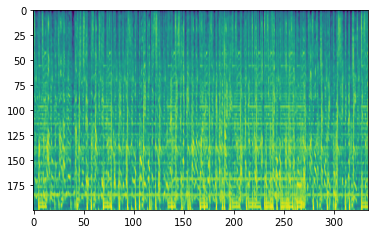

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 2.0000000e+00  3.9690730e-01  2.4936402e-03  1.0000000e+00
  2.9430017e-01  1.4519466e-01  2.1372719e-02  4.0085819e-01
  7.8943834e-02  3.0376462e+03  8.2565656e+02  6.8770391e+03
  9.9045245e+02  2.6901113e+03  1.5655203e+03  3.7333093e+03
  3.5741660e+02  6.2146641e+03  1.5180908e+03  9.6468750e+03
  1.5103333e+03  1.6371983e-01  2.9296875e-02  6.1181641e-01
  9.3396619e-02 -6.7384224e+01  6.5154984e+01 -1.0669198e+01
  1.2176895e+01 -3.3035460e+00  9.9164639e+00 -1.9857939e+00
  5.4153090e+00 -6.1618333e+00  1.0913678e+00 -1.0330084e+01
  3.4071732e+00 -3.0144753e+00  8.1967850e+00 -3.3063750e+00
  1.2533796e+00 -8.4815273e+00 -2.0407531e+00 -2.9466519e+00
  9.4058223e-02]


In [14]:
plt.imshow(image)
plt.show()
print(label)
print(feature)

In [15]:
features_scaled = StandardScaler().fit_transform(features[:, 1:])
ids = np.swapaxes(np.expand_dims(features[:,0],axis=0), 0, 1)
features_scaled = np.append(ids, features_scaled, axis=1)

In [16]:
print(features_scaled.shape)
print(features.shape)

(107677, 45)
(107677, 45)


In [17]:
# define test and train data set
test_split = .2
from sklearn.model_selection import train_test_split

train_images, test_images, train_labels, test_labels= train_test_split(images, labels, test_size=test_split, random_state=42)
feat_train_values, feat_test_values, feat_train_labels, feat_test_labels = train_test_split(features_scaled, labels, test_size=test_split, random_state=42)

In [18]:
print(features_scaled[0])

[ 2.          0.0569877  -0.41504338  0.01396659  0.29682478 -0.41355696
 -0.6361011   0.36840484  0.7103717   1.6076787   0.119418    1.7914585
  1.2514628   1.085459    0.87294555  0.83149016 -0.22899364  1.4558337
  0.18382207  0.99173594  0.32067627  1.829522    0.54907477  2.2172074
  2.0947247   0.5551605  -1.2088784  -0.2114808  -0.9347997  -0.5516039
  0.13040666 -0.03320878  0.07824428 -0.30129945 -0.23934232 -1.072306
  0.2486938   0.14722879  1.3505737   0.1755924   0.11312366 -0.84782976
 -0.50638306  0.16084853 -0.03000231]


In [19]:
print(len(feat_train_values[0]))
print(len(feat_test_values[0]))

print(feat_train_values[0])
print(feat_test_values[0])

45
45
[ 7.2010000e+04  1.0387785e+00  1.3365521e+00  1.3966595e-02
 -8.7210822e-01  1.3339697e-01  1.2637736e+00  7.1142100e-02
  4.7316819e-02 -1.1503233e+00 -9.8451728e-01 -6.1508089e-01
 -1.9667174e-01 -4.3291745e-01 -8.6832249e-01  5.4487038e-01
  1.2403951e+00 -1.0032476e+00 -8.3518744e-01  2.7843490e-01
  5.5607992e-01 -1.3026795e+00 -6.8891418e-01 -1.3342928e+00
 -1.1071923e+00 -5.2404201e-01  6.5286726e-01  7.5924242e-01
 -2.8228176e-01  2.2157044e+00  1.9211088e+00  1.7717097e+00
  1.2361162e+00  1.3005053e-01  1.5774167e-01  1.7791585e+00
  1.2167827e+00  1.3170612e+00 -1.3776243e+00 -1.6992319e+00
  3.2230324e-01  3.1350360e+00  2.4061663e+00  1.9768475e+00
  2.0802324e-01]
[ 5.7997000e+04  8.5159701e-01 -4.6467093e-01  1.3966595e-02
  1.5823674e-01 -1.7615864e-01 -5.5506474e-01 -2.6305628e-01
  1.7680874e-01  4.4274890e-01  3.4796610e-01 -4.9575567e-01
 -6.4870465e-01  3.4932202e-01  3.1029031e-01 -2.6214314e-01
 -4.4407579e-01  3.5285854e-01  9.6539241e-01 -2.0262861e-01
 

In [20]:
# grab the track ids before deleting them from our train and test list since
# we dont want out model seeing on those
train_track_ids = []
test_track_ids = []
for sample in feat_train_values:
  train_track_ids.append(sample[0])
feat_train_values = np.delete(feat_train_values, 0, 1)
for sample in feat_test_values:
  test_track_ids.append(sample[0])
feat_test_values = np.delete(feat_test_values, 0, 1)
    
print(len(feat_train_values[0]))
print(len(feat_test_values[0]))

44
44


In [21]:
print(len(feat_train_values[0]))
print(len(feat_test_values[0]))

print(feat_train_values[0])
print(feat_test_values[0])

44
44
[ 1.0387785   1.3365521   0.01396659 -0.8721082   0.13339697  1.2637736
  0.0711421   0.04731682 -1.1503233  -0.9845173  -0.6150809  -0.19667174
 -0.43291745 -0.8683225   0.5448704   1.2403951  -1.0032476  -0.83518744
  0.2784349   0.5560799  -1.3026795  -0.6889142  -1.3342928  -1.1071923
 -0.524042    0.65286726  0.7592424  -0.28228176  2.2157044   1.9211088
  1.7717097   1.2361162   0.13005053  0.15774167  1.7791585   1.2167827
  1.3170612  -1.3776243  -1.6992319   0.32230324  3.135036    2.4061663
  1.9768475   0.20802324]
[ 0.851597   -0.46467093  0.01396659  0.15823674 -0.17615864 -0.55506474
 -0.26305628  0.17680874  0.4427489   0.3479661  -0.49575567 -0.64870465
  0.34932202  0.3102903  -0.26214314 -0.4440758   0.35285854  0.9653924
 -0.20262861 -0.57416004  0.3343833  -0.21060029 -0.42030367 -0.25012034
  0.43235373 -0.7075097  -0.6784804   0.77284974  0.27739087  0.3298995
  1.4739943   1.9284614   0.9343922   1.10502     1.4176599   0.5875867
 -0.16306208 -1.0133411   0

In [22]:
# free memory 
images = None
features = None
labels = None

In [23]:
# Reshape images to 200x335 pixels
train_images = train_images.reshape(train_images.shape[0], IMG_HEIGHT, IMG_WIDTH, 1)
test_images = test_images.reshape(test_images.shape[0], IMG_HEIGHT, IMG_WIDTH, 1)

In [24]:
print(train_images[0].shape)

(200, 335, 1)


[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]


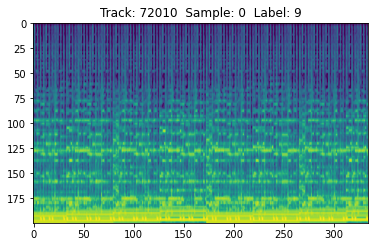

In [25]:
import matplotlib.pyplot as plt

def display_sample(num):
    #Print the one-hot array of this sample's label 
    print(train_labels[num])  
    #Print the label converted back to a number
    label = train_labels[num].argmax(axis=0)
    #Reshape the lots of values to a 423x288 image
    image = train_images[num].reshape([IMG_HEIGHT, IMG_WIDTH])
    plt.title('Track: %d  Sample: %d  Label: %d' % (train_track_ids[num], num, label))
    plt.imshow(image) #, cmap=plt.get_cmap('gray_r'))
    plt.show()
    
display_sample(0)

In [26]:
# Initialize the image classifier.
clf = ak.ImageClassifier(
    project_name="fma_classifier",
    max_trials=1,
    multi_label=True
)

# Feed the image classifier with training data.
clf.fit(train_images, train_labels, validation_data=(test_images, test_labels), epochs=5)

INFO:tensorflow:Reloading Oracle from existing project .\fma_classifier\oracle.json
INFO:tensorflow:Reloading Tuner from .\fma_classifier\tuner0.json
INFO:tensorflow:Oracle triggered exit
Epoch 1/5
2692/2692 [==============================] - 6583s 2s/step - loss: 0.1404 - accuracy: 0.3507 - val_loss: 0.1297 - val_accuracy: 0.3834
Epoch 2/5
2692/2692 [==============================] - 6564s 2s/step - loss: 0.1192 - accuracy: 0.4288 - val_loss: 0.1262 - val_accuracy: 0.4032
Epoch 3/5
2692/2692 [==============================] - 6574s 2s/step - loss: 0.0995 - accuracy: 0.5236 - val_loss: 0.1416 - val_accuracy: 0.4007
Epoch 4/5
2692/2692 [==============================] - 6569s 2s/step - loss: 0.0844 - accuracy: 0.5950 - val_loss: 0.1633 - val_accuracy: 0.4160
Epoch 5/5
2692/2692 [==============================] - 6632s 2s/step - loss: 0.0724 - accuracy: 0.6507 - val_loss: 0.1942 - val_accuracy: 0.4208
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updat

In [27]:
test_loss, test_acc = clf.evaluate(test_images, test_labels)
print("Test Accuracy: {:4.1f}%".format(test_acc * 100))

673/673 [==============================] - 324s 482ms/step - loss: 0.1942 - accuracy: 0.4208
Test Accuracy: 42.1%


In [28]:
model = clf.export_model()
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 335, 1)]     0         
_________________________________________________________________
tf_op_layer_Cast (TensorFlow (None, 200, 335, 1)       0         
_________________________________________________________________
normalization (Normalization (None, 200, 335, 1)       3         
_________________________________________________________________
conv2d (Conv2D)              (None, 198, 333, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 196, 331, 64)      18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 98, 165, 64)       0         
_________________________________________________________________
dropout (Dropout)            (None, 98, 165, 64)      

In [29]:
# feature layers
feat_input = keras.Input(shape=(feat_train_values.shape[1],), name='feat_input')
x = keras.layers.Dense(256, activation='relu')(feat_input)
x = keras.layers.Dense(128, activation='relu')(x)
feat_layers = keras.layers.Dense(64, activation='relu')(x)

# image convolutional layers
img_input = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1), name="img_input")
x = keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu')(img_input)
x = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2))(x)
x = keras.layers.Dropout(0.25)(x)
x = keras.layers.Flatten()(x)
img_layers = keras.layers.Dropout(0.5)(x)

# concatenate img layers with feature layers and define output layer
combined = keras.layers.concatenate([img_layers, feat_layers])
out_layer = keras.layers.Dense(32, activation='sigmoid')(combined)

# define model with both image and feature inputs
model = keras.Model(inputs=[feat_input, img_input], outputs=out_layer)

In [30]:
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [31]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_input (InputLayer)          [(None, 200, 335, 1) 0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 198, 333, 32) 320         img_input[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 99, 166, 32)  0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
feat_input (InputLayer)         [(None, 44)]         0                                            
_______________________________________________________________________________________

In [32]:
# compile model
model.compile(optimizer='adam',
          loss=keras.losses.binary_crossentropy,
          metrics=['accuracy'])

# train model
BATCH_SIZE = 64 
NUM_EPOCHS = 15 

In [33]:
  print(train_images.shape, train_labels.shape, test_images.shape, test_labels.shape)
  print(feat_train_values.shape, feat_train_labels.shape, feat_test_values.shape, feat_test_labels.shape)

(86141, 200, 335, 1) (86141, 32) (21536, 200, 335, 1) (21536, 32)
(86141, 44) (86141, 32) (21536, 44) (21536, 32)


In [34]:
# fit model
history = model.fit(x=[feat_train_values, train_images], y=train_labels, 
                    validation_data=([feat_test_values, test_images], test_labels), 
                    batch_size=BATCH_SIZE, epochs=NUM_EPOCHS) 

Epoch 1/15
1346/1346 [==============================] - 1702s 1s/step - loss: 3.7726 - accuracy: 0.2785 - val_loss: 0.1701 - val_accuracy: 0.3515
Epoch 2/15
1346/1346 [==============================] - 1700s 1s/step - loss: 0.1472 - accuracy: 0.3723 - val_loss: 0.1409 - val_accuracy: 0.3843
Epoch 3/15
1346/1346 [==============================] - 1696s 1s/step - loss: 0.1264 - accuracy: 0.4185 - val_loss: 0.1334 - val_accuracy: 0.3900
Epoch 4/15
1346/1346 [==============================] - 1699s 1s/step - loss: 0.1196 - accuracy: 0.4409 - val_loss: 0.1310 - val_accuracy: 0.3974
Epoch 5/15
1346/1346 [==============================] - 1695s 1s/step - loss: 0.1159 - accuracy: 0.4569 - val_loss: 0.1303 - val_accuracy: 0.4062
Epoch 6/15
1346/1346 [==============================] - 1698s 1s/step - loss: 0.1136 - accuracy: 0.4674 - val_loss: 0.1308 - val_accuracy: 0.4019
Epoch 7/15
1346/1346 [==============================] - 1696s 1s/step - loss: 0.1112 - accuracy: 0.4762 - val_loss: 0.1294 -

673/673 - 87s - loss: 0.1364 - accuracy: 0.4270


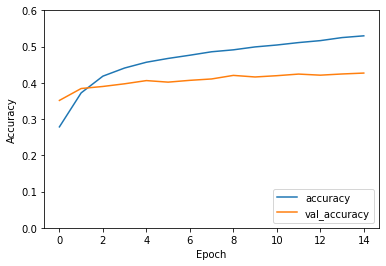

In [35]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, .6])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate([feat_test_values, test_images], test_labels, verbose=2)

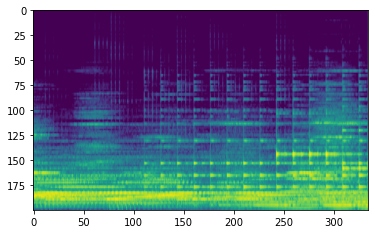

In [36]:
# test = model.predict(test_images[0].reshape([img_height, img_width]))
num = 9999
test = test_images[num].reshape([IMG_HEIGHT, IMG_WIDTH])
plt.imshow(test)
plt.show()

In [37]:
prediction = model.predict([np.array([feat_test_values[num]]), np.array([test_images[num]])])
prediction

array([[1.1646373e-09, 4.3319569e-06, 6.0866153e-01, 5.1942003e-08,
        4.8737930e-10, 4.4375506e-06, 2.6261185e-05, 1.6999213e-16,
        2.3533168e-18, 2.0772934e-02, 1.4459660e-05, 1.3483167e-03,
        3.5575948e-23, 1.2967481e-10, 5.7816243e-07, 1.5732179e-11,
        4.3540345e-09, 2.4731357e-08, 2.1875278e-15, 1.6671169e-10,
        2.7032134e-09, 4.1186490e-06, 7.2157696e-11, 5.3064007e-17,
        1.4641932e-10, 7.8407526e-03, 3.1659021e-17, 1.8427509e-15,
        1.3791021e-14, 4.6884637e-15, 2.6852105e-14, 6.5611005e-03]],
      dtype=float32)

In [38]:
# top 3 predictions
top3 = np.argsort(-prediction[0])[:5]
for i, val in enumerate(top3, start=1):
  print('#{}: {}'.format(i, labels_key[val]))

#1: Classical
#2: Electronic
#3: Ambient
#4: Instrumental
#5: Soundtrack


In [39]:
# actual label
# print(labels[test_labels[img_num]])
print(test_labels[num])
for i, v in enumerate(test_labels[num]):
  if v == 1:
    print(labels_key[i])


[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Soundtrack


In [40]:
model.save('./FMA_model_seperate_genres_fix.h5')